# Task for IP

## Overview

The task at hand is to evaluate the impact of YOY change in school size to performance on state tests for schools in Tennessee and Texas.

### Approach
Data is pulled from public data sources here (https://www.tn.gov/education/data/data-downloads.html) and here (https://tea.texas.gov/texas-schools/accountability/academic-accountability/performance-reporting/texas-academic-performance-reports). Data was pulled for the 3 most recent, complete school years; given the interruptions that COVID had on the 2019-2020 school year, those data were incomplete, so I pulled information from the 2016-17, 2017-18, and 2018-19 school years.

For TN - I selected state Accountability records and the Enrollment data. From the Accountability data, I selected information about performance for key subjects (ELA, Math, Social Studies, HS English, HS Math, and HS History), specifically the percent of students at each school who were on target or mastering the subject. From Enrollment data, I selected information specifically on total school population, ignoring more nuanced data about student demographic breakdowns for this analysis. This decision was made primarily due to the lack of 1:1 ethnic/race groups available for the Accountability data.

For TX - I selected Campus level data and first extracted the Accountability reports. These reports also linked to a separate table with a glossary of table column translations - I copy and pasted these into excel files and saved those to the working folder. The Accountability reports included information about total enrollment for the school year at each campus. I then selected Academic performance data, primarily data about percentage of students meeting expectation rates on the STAAR assesments. I selected data rolled up for all subject by campus, but would link in mulitple sources to break performance out across subjects if I went deeper on this analysis.

After combining enrollment data, I calculated a Year-over-Year rate of change for each campus to standardize growth. Another approach that was considered would be to simply calculate the change in the actual number of seats in each school, but for the sake of this exercise, I chose to work with proportional change.

To measure change in academic proficiency, I simply took the difference between percent of students 'on target/mastered' from the current year from the previous. Academic and enrollment data were combined - for TN, I was able to combine the change in campus size with performance on a number of subjects for each campus. For TX - I combined the performance rate on all tests with the rate of change in campus size.

Outlier data were removed. Rows with Null values or place holder values in place of critical information were dropped.

### Analysis
My thought to use rate of change in size allowed for a lagged outcome to present itself. The delta between Year 1 and Year 2 would present itself in Year 2 test scores, as the impact of the addition or loss of students was absorbed by the campus.

Because we were curious about how the change in size impacted performance, I used the mean of growth rate as a point to split my academic performance into groups (proficiency at campuses experiencing above/below average).

Once the populations were split, I conducted a Levene test to test whether variance of the populations were equal. If variance were equal, I conducted independent Students t-test; if they did not have equal variance, I substituted Welch's t-test.

With the t-test, I was testing the following null hypothesis:

H0: Mean(group1) = Mean(group2)  
H1: Mean(group1) != Mean(group2)

If I uncovered a p-value < 0.05 (my alpha level of significance), I had enough evidence to reject the null hypothesis, allowing me to conclude there was a statistically significant difference in group means, where the groups were split by the rate of change in school population size (and by test subject in the case of TN data).

### Findings
In TN, performance in HS English and ELA showed statistically significant differences in the change in student performance levels as a result of school growth.

In TX, campuses that shrank (those with negative growth rates) saw greater gains in proficiency levels than those campuses that grew over the same time period.

### Challenges
- General - time consuming to have to work across tables that did not have standarized headings added an extra step to determine the information that was at hand.
- TN - tried to disaggregate too much - needed to keep all data at all students because there was no performance data split in the same demographic groups as the Academic performance data.
- TX - assessment design changes (led to ommision of 16-17 data), initial confusion on the reverse cumulative structure of Approaching, Meets, Mastered performance breakouts for Academic data.

### Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from scipy.stats import ttest_ind, levene

import warnings
warnings.filterwarnings('ignore')

### Data Load
#### Tennessee

In [2]:
xls = pd.ExcelFile('TN_15_16_Enrollment.xlsx')
TN1516Enrl = pd.read_excel(xls, '2015-2016 Membership File')

TN1617Acct = pd.read_excel('TN_16_17_Accountability.xlsx')
xls = pd.ExcelFile('TN_16_17_Enrollment.xlsx')
TN1617Enrl = pd.read_excel(xls, '2016-2017 Membership File')

TN1718Acct = pd.read_excel('TN_17_18_Accountability.xlsx')
TN1718Enrl = pd.read_excel('TN_17_18_Enrollment.xlsx')

TN1819Acct = pd.read_excel('TN_18_19_Accountability.xlsx')
TN1819Enrl = pd.read_excel('TN_18_19_Enrollment.xlsx')

#### Texas

In [3]:
#Load in all data for TX - first the enrollment data and table keys
TX1617 = pd.read_excel('TX_16_17_FullData.xlsx')
TX1718 = pd.read_excel('TX_17_18_FullData.xlsx')
TX1819 = pd.read_excel('TX_18_19_FullData.xlsx')
TX1617Key = pd.read_excel('TX17Key.xlsx')
TX1718Key = pd.read_excel('TX18Key.xlsx')
TX1819Key = pd.read_excel('TX19Key.xlsx')

#Then the academic data with the table keys
TX1617Aca = pd.read_excel('TX_16_17_Academic.xlsx')
TX1718Aca = pd.read_excel('TX_17_18_Academic.xlsx')
TX1819Aca = pd.read_excel('TX_18_19_Academic.xlsx')
TX1617AcaKey = pd.read_excel('TX_16_17_Academic_Key.xlsx')
TX1718AcaKey = pd.read_excel('TX_17_18_Academic_Key.xlsx')
TX1819AcaKey = pd.read_excel('TX_18_19_Academic_Key.xlsx')

### Data Prep

As we see below, there is no common race/ethnicity to join across the tables - the best that could be done would be a combination of Enrollment Race to match the Black/Hispanic/Native American Accountability subgroup; I won't be doing that during this exercise.

In [4]:
#This is a check to see if it is possible to combine Enrollment and Accademic achievement 
#data in a meaningful way at a disaggregated level (there is not)
print(list(set(TN1617Enrl.RACE)))

print(list(set(TN1617Acct.subgroup)))

['All Race/Ethnic Groups', 'Native Hawaiian or Other Pacific Islander', 'Hispanic or Latino ethnicity', 'Black or African American', 'American Indian or Alaskan Native', 'White', 'Two or more races', 'Asian']
['All Students', 'Super Subgroup', 'Economically Disadvantaged', 'Black/Hispanic/Native American', 'Students with Disabilities', 'English Learners']


Below, I inspect the total number of schools present in the data sets for each given year/data cut.

In [5]:
#Do some renaming of columns of the Enrollment data for ease of use
TN1516Enrl = TN1516Enrl.rename(columns={'DISTRICT_ID': 'DISTRICT', 'DISTRICT_NAME': 'DISTRICT NAME', 
                                        'SCHOOL_ID': 'SCHOOL', 'SCHOOL_NAME': 'SCHOOL NAME', 'RACE_OR_ETHNICITY': 'RACE'})
TN1617Enrl = TN1617Enrl.rename(columns={'DISTRICT_ID': 'DISTRICT', 'DISTRICT_NAME': 'DISTRICT NAME', 
                                        'SCHOOL_ID': 'SCHOOL', 'SCHOOL_NAME': 'SCHOOL NAME'})
TN1718Enrl = TN1718Enrl.rename(columns={'GRADE ': 'GRADE'})

In [6]:
#For each of the enrollment tables, print the total number of unique schools in the set
Enroll = {'1516': TN1516Enrl, '1617': TN1617Enrl, '1718': TN1718Enrl, '1819': TN1819Enrl}
Acct = {'1617': TN1617Acct, '1718': TN1718Acct, '1819': TN1819Acct}

for i in Enroll.keys():
    print('Total {} TN schools - '.format(i), len(list(set(Enroll[i]['DISTRICT'].astype('str') + ' ' + Enroll[i]['SCHOOL'].astype('str')))))

for i in Acct.keys():
    print('Total {} TN schools - '.format(i), len(list(set(Acct[i]['system'].astype('str') + ' ' + Acct[i]['school'].astype('str')))))

Total 1516 TN schools -  1790
Total 1617 TN schools -  1774
Total 1718 TN schools -  1745
Total 1819 TN schools -  1758
Total 1617 TN schools -  1719
Total 1718 TN schools -  1705
Total 1819 TN schools -  1712


Below I pair the Enrollment data down significantly. I am interested in total school size, and do not currently have the disaggregation in performance data to match with enrollment data, so I can pull out just the summary lines that roll up All Grades, All Race/Ethnic Groups, and All Genders.

In [7]:
#For each of the TN Enrollment tables, print the length of the table.
#Select the aggregated data for each school and then generate a join key
#Print the length again to see what the loss of data was.
print(len(TN1516Enrl))
for i in TN1516Enrl.columns[:7]:
    TN1516Enrl[i] = TN1516Enrl[i].astype('str')
TN1516Enrl = TN1516Enrl[TN1516Enrl['GRADE'] == 'All Grades']
TN1516Enrl = TN1516Enrl[TN1516Enrl['RACE'] == 'All Race/Ethnic Groups']
TN1516Enrl = TN1516Enrl[TN1516Enrl['GENDER'] == 'All Genders']
TN1516Enrl['join'] = TN1516Enrl['DISTRICT'] + ' ' + TN1516Enrl['SCHOOL']
print(len(TN1516Enrl))

print(len(TN1617Enrl))
for i in TN1617Enrl.columns[:7]:
    TN1617Enrl[i] = TN1617Enrl[i].astype('str')
TN1617Enrl = TN1617Enrl[TN1617Enrl['GRADE'] == 'All Grades']
TN1617Enrl = TN1617Enrl[TN1617Enrl['RACE'] == 'All Race/Ethnic Groups']
TN1617Enrl = TN1617Enrl[TN1617Enrl['GENDER'] == 'All Genders']
TN1617Enrl['join'] = TN1617Enrl['DISTRICT'] + ' ' + TN1617Enrl['SCHOOL']
print(len(TN1617Enrl))

print(len(TN1718Enrl))
for i in TN1718Enrl.columns[:7]:
    TN1718Enrl[i] = TN1718Enrl[i].astype('str')
TN1718Enrl = TN1718Enrl[TN1718Enrl['GRADE'] == 'All Grades']
TN1718Enrl = TN1718Enrl[TN1718Enrl['RACE'] == 'All Race/Ethnic Groups']
TN1718Enrl = TN1718Enrl[TN1718Enrl['GENDER'] == 'All Genders']
TN1718Enrl['join'] = TN1718Enrl['DISTRICT'] + ' ' + TN1718Enrl['SCHOOL']
print(len(TN1718Enrl))

print(len(TN1819Enrl))
for i in TN1819Enrl.columns[:7]:
    TN1819Enrl[i] = TN1819Enrl[i].astype('str')
TN1819Enrl = TN1819Enrl[TN1819Enrl['GRADE'] == 'All Grades']
TN1819Enrl = TN1819Enrl[TN1819Enrl['RACE'] == 'All Race/Ethnic Groups']
TN1819Enrl = TN1819Enrl[TN1819Enrl['GENDER'] == 'All Genders']
TN1819Enrl['join'] = TN1819Enrl['DISTRICT'] + ' ' + TN1819Enrl['SCHOOL']
print(len(TN1819Enrl))

163280
1790
151776
1774
230286
1745
294240
1758


In [8]:
#Generate the Enrollment table, which is a combination of enrollment from the last 4 years
Enrollment = pd.merge(TN1516Enrl, TN1617Enrl, on = 'join', how = 'right', suffixes=('_1516','_1617'))
Enrollment = pd.merge(Enrollment, TN1718Enrl, on = 'join', how = 'right')
Enrollment = pd.merge(Enrollment, TN1819Enrl, on = 'join', how = 'right', suffixes=('_1718','_1819'))

#Select the necessary columns from the above joins
Enrollment = Enrollment[['join', 'DISTRICT_1819', 'SCHOOL_1819', 'ENROLLMENT_1516', 
                         'ENROLLMENT_1617', 'ENROLLMENT_1718', 'ENROLLMENT_1819']]

Enrollment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1758 entries, 0 to 1757
Data columns (total 7 columns):
join               1758 non-null object
DISTRICT_1819      1758 non-null object
SCHOOL_1819        1758 non-null object
ENROLLMENT_1516    1703 non-null float64
ENROLLMENT_1617    1722 non-null float64
ENROLLMENT_1718    1733 non-null float64
ENROLLMENT_1819    1758 non-null int64
dtypes: float64(3), int64(1), object(3)
memory usage: 109.9+ KB


In [9]:
#Generate a growth rate for each year, calculating the rate of change in size of each school between the 16-17/17-18/18-19
Enrollment['GR1617'] = round((Enrollment['ENROLLMENT_1617'] - Enrollment['ENROLLMENT_1516']) / Enrollment['ENROLLMENT_1516'],4)
Enrollment['GR1718'] = round((Enrollment['ENROLLMENT_1718'] - Enrollment['ENROLLMENT_1617']) / Enrollment['ENROLLMENT_1617'],4)
Enrollment['GR1819'] = round((Enrollment['ENROLLMENT_1819'] - Enrollment['ENROLLMENT_1718']) / Enrollment['ENROLLMENT_1718'],4)
Enrollment.head()

,join,DISTRICT_1819,SCHOOL_1819,ENROLLMENT_1516,ENROLLMENT_1617,ENROLLMENT_1718,ENROLLMENT_1819,GR1617,GR1718,GR1819
0,10 2,10,2,1123.0,1054.0,1056.0,1074,-0.0614,0.0019,0.0170
1,10 5,10,5,333.0,342.0,310.0,338,0.0270,-0.0936,0.0903
2,10 10,10,10,119.0,128.0,109.0,127,0.0756,-0.1484,0.1651
3,10 15,10,15,541.0,529.0,459.0,486,-0.0222,-0.1323,0.0588
4,10 20,10,20,634.0,651.0,666.0,664,0.0268,0.0230,-0.0030


In [10]:
#For each of the Accountability data sets, remove any duplicate fields - 
#This removes any of the rows where the performance data is split out by grades, keeiping
#just the rows where All Students' scores are summarized - there is now just one
#row per system/school/subject
TN1617Acct = TN1617Acct.drop_duplicates(['system', 'school', 'subject', 'grade'])
TN1617Acct['join'] = TN1617Acct['system'].astype('str') + ' ' + TN1617Acct['school'].astype('str') + ' ' + TN1617Acct['subject'] + ' ' + TN1617Acct['grade']
TN1617Acct = TN1617Acct[['join', 'year', 'system', 'school', 'subject', 'grade', 'valid_tests', 'pct_on_mastered']]
TN1617Acct = TN1617Acct[(TN1617Acct['pct_on_mastered'] != '*') & (TN1617Acct['pct_on_mastered'] != '**')]

TN1718Acct = TN1718Acct.drop_duplicates(['system', 'school', 'subject', 'grade'])
TN1718Acct['join'] = TN1718Acct['system'].astype('str') + ' ' + TN1718Acct['school'].astype('str') + ' ' + TN1718Acct['subject'] + ' ' + TN1718Acct['grade']
TN1718Acct = TN1718Acct[['join', 'year', 'system', 'school', 'subject', 'grade', 'valid_tests', 'pct_on_mastered']]
TN1718Acct = TN1718Acct[(TN1718Acct['pct_on_mastered'] != '*') & (TN1718Acct['pct_on_mastered'] != '**')]

TN1819Acct = TN1819Acct.drop_duplicates(['system', 'school', 'subject', 'grade'])
TN1819Acct['join'] = TN1819Acct['system'].astype('str') + ' ' + TN1819Acct['school'].astype('str') + ' ' + TN1819Acct['subject'] + ' ' + TN1819Acct['grade']
TN1819Acct = TN1819Acct[['join', 'year', 'system', 'school', 'subject', 'grade', 'valid_tests', 'pct_on_mastered']]
TN1819Acct = TN1819Acct[(TN1819Acct['pct_on_mastered'] != '*') & (TN1819Acct['pct_on_mastered'] != '**')]

In [11]:
#Generate the Accountability table by combining the academic achievement data sets
Accountability = pd.merge(TN1617Acct, TN1718Acct, on = 'join', how = 'right', suffixes=('_1617', '_1718'))
Accountability = pd.merge(Accountability, TN1819Acct, on = 'join', how = 'right')

#Select the appropriate columns from Accountability
Accountability = Accountability[['system', 'school', 'subject', 'grade',
                                 'pct_on_mastered_1617', 'pct_on_mastered_1718', 'pct_on_mastered']]

Accountability.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5041 entries, 0 to 5040
Data columns (total 7 columns):
system                  5041 non-null int64
school                  5041 non-null int64
subject                 5041 non-null object
grade                   5041 non-null object
pct_on_mastered_1617    3931 non-null object
pct_on_mastered_1718    4867 non-null object
pct_on_mastered         5041 non-null object
dtypes: int64(2), object(5)
memory usage: 315.1+ KB


In [12]:
#Generate a join key on the Accountability table to join the Enrollment information
Accountability['join'] = Accountability['system'].astype('str') + ' ' + Accountability['school'].astype('str')

#Make a dataframe AandE that combines information from the Enrollment and Academic data
AandE = pd.merge(Accountability, Enrollment[['join', 'GR1617', 'GR1718', 'GR1819']], how = 'inner', on = 'join')

#Generate Academic Growth fields, which are the delta in points between current and prior year pct on target or mastered
AandE['Ac1718'] = (AandE['pct_on_mastered_1718'] - AandE['pct_on_mastered_1617']).astype('float64')
AandE['Ac1819'] = (AandE['pct_on_mastered'] - AandE['pct_on_mastered_1718']).astype('float64')

In [13]:
#Find outliers in the data by calculating +/- 3 standard deviations from the mean

a = {}
for i in ['GR1617', 'GR1718', 'GR1819', 'Ac1718', 'Ac1819']:
    a[i] = (round(np.mean(AandE[i])-(3*(np.std(AandE[i]))),3), round(np.mean(AandE[i])+(3*(np.std(AandE[i]))),3))
    
a

{'GR1617': (-0.362, 0.39),
 'GR1718': (-0.426, 0.389),
 'GR1819': (-0.288, 0.355),
 'Ac1718': (-21.999, 19.508),
 'Ac1819': (-19.829, 24.511)}

In [14]:
#Here I am removing outliers that are +/- 3 Stds away from mean.
#I want to keep the Null values in Ac1718 and Ac1819 so I can caluclate Social Studies 
#and US History for 2018-19 - many seem to be null on the Ac1718
AandE = AandE[(AandE['GR1617'] >= -.362) & (AandE['GR1617'] <= 0.39)]
AandE = AandE[(AandE['GR1718'] >= -.426) & (AandE['GR1718'] <= 0.389)]
AandE = AandE[(AandE['GR1819'] >= -.288) & (AandE['GR1819'] <= 0.355)]
AandE = AandE[((AandE['Ac1718'] >= -21.999) & (AandE['Ac1718'] <= 19.508)) | AandE['Ac1718'].isna()]
AandE = AandE[(AandE['Ac1819'] >= -19.829) & (AandE['Ac1819'] <= 24.511) | AandE['Ac1819'].isna()]
AandE.describe()

,system,school,GR1617,GR1718,GR1819,Ac1718,Ac1819
count,4685.000000,4685.000000,4685.000000,4685.000000,4685.000000,3742.000000,4585.00000
mean,509.987834,522.987407,0.001382,-0.030452,0.026017,-1.201309,2.35193
std,287.008952,1633.200904,0.074105,0.080361,0.076062,6.338050,6.66928
min,10.000000,1.000000,-0.345100,-0.406000,-0.286400,-21.700000,-19.60000
25%,231.000000,20.000000,-0.036600,-0.076200,-0.019900,-5.200000,-2.00000
50%,530.000000,45.000000,-0.003000,-0.027100,0.019100,-1.100000,2.10000
75%,792.000000,104.000000,0.032100,0.016800,0.064600,2.800000,6.60000
max,985.000000,8280.000000,0.380000,0.319900,0.353600,19.100000,24.50000


In [15]:
#Quick check that we do have values across all subjects
AandE.subject.value_counts()

ELA               1623
Math              1596
Social Studies     576
HS English         326
HS Math            307
US History         257
Name: subject, dtype: int64

### TN Analysis
#### TN Trial 1 17-18

Below I will split the data into two groups, schools which were at or below the average growth rate (-3.2%) for the 16-17 -> 18-19 school year. I will then calculate a levene test to check for equal variance and perform a Student's or Welch's t-test accordingly to test the null hypothesis that there is no difference in the mean delta of academic performance between groups that changed size at different rates.

In [16]:
#Splitting the data into positive and less than mean growth rate

# Test 1 is positive growth rate
# Test 2 is below average growth rate

Test1 = AandE[AandE['GR1718'] > 0]
Test2 = AandE[AandE['GR1718'] <= -0.030452]

print(len(Test1))
print(len(Test2))
print(' ')

a = Test1[Test1['subject'] == 'Math']
b = Test1[Test1['subject'] == 'ELA']
c = Test1[Test1['subject'] == 'HS Math']
d = Test1[Test1['subject'] == 'HS English']
a = a.dropna(subset=['Ac1718'])
b = b.dropna(subset=['Ac1718'])
c = c.dropna(subset=['Ac1718'])
d = d.dropna(subset=['Ac1718'])
for i in [a, b, c, d]:
    i = i.dropna()
    print(len(i))

print(' ')
m = Test2[Test2['subject'] == 'Math']
n = Test2[Test2['subject'] == 'ELA']
o = Test2[Test2['subject'] == 'HS Math']
p = Test2[Test2['subject'] == 'HS English']
m = m.dropna(subset=['Ac1718'])
n = n.dropna(subset=['Ac1718'])
o = o.dropna(subset=['Ac1718'])
p = p.dropna(subset=['Ac1718'])
for i in [m, n, o, p]:
    print(len(i))

1600
2259
 
475
486
123
128
 
834
857
87
107


In [17]:
#Calculate the Levene test for equal variance for each of the subject pairs
#If p-value is < alpha, populations do not have equal variance and Welch's
#t-test must substitute for Students
print(levene(a['Ac1718'], m['Ac1718']))
print(levene(b['Ac1718'], n['Ac1718']))
print(levene(c['Ac1718'], o['Ac1718']))
print(levene(d['Ac1718'], p['Ac1718']))

LeveneResult(statistic=6.830174300244695, pvalue=0.009065967772144821)
LeveneResult(statistic=3.045338704114774, pvalue=0.08119828041578174)
LeveneResult(statistic=2.3352732610119293, pvalue=0.12799206366204266)
LeveneResult(statistic=3.487629161835747, pvalue=0.06308465119067527)


In [18]:
#Only the comparison test for Math populations substitutes Welch's due to the unequal variance
print('Less than mean GR vs positive GR')
print('Math', round(np.mean(a['Ac1718']),3), round(np.mean(m['Ac1718']),3), 
      round(ttest_ind(a['Ac1718'], m['Ac1718'], equal_var=False)[1],3))
print('ELA', round(np.mean(b['Ac1718']),3), round(np.mean(n['Ac1718']),3), 
      round(ttest_ind(b['Ac1718'], n['Ac1718'])[1],3))
print('HS Math', round(np.mean(c['Ac1718']),3), round(np.mean(o['Ac1718']),3), 
      round(ttest_ind(c['Ac1718'], o['Ac1718'])[1],3))
print('HS English', round(np.mean(d['Ac1718']),3), round(np.mean(p['Ac1718']),3), 
      round(ttest_ind(d['Ac1718'], p['Ac1718'])[1],3))

Less than mean GR vs positive GR
Math -1.608 -1.109 0.184
ELA -0.573 0.021 0.083
HS Math -1.772 -0.801 0.202
HS English -7.459 -5.039 0.0


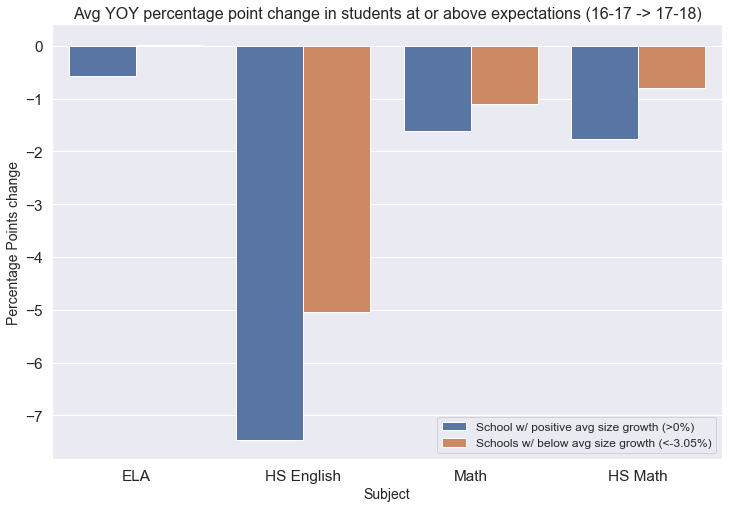

In [19]:
#Select a subset of the data that mirror the above tested groups
TNViz = AandE[(AandE['GR1718'] > 0) | (AandE['GR1718'] <= -0.030452)]

#Separate the data dependent on the 1718 Growth Rate
TNViz['hue'] = ['School w/ positive avg size growth (>0%)' if i > 0 
                else 'Schools w/ below avg size growth (<-3.05%)' for i in TNViz['GR1718']]

#Generate a boxplot showing the average change in percentage points
order=['ELA', 'HS English', 'Math', 'HS Math']
plt.figure(figsize=(12,8))
sns.set_style('darkgrid')
sns.set(font_scale=1.4)
sns.barplot(x='subject', y='Ac1718', hue='hue', order=order, data=TNViz, ci=False)
plt.title('Avg YOY percentage point change in students at or above expectations (16-17 -> 17-18)', fontsize=16)
plt.ylabel('Percentage Points change', fontsize=14)
plt.xlabel('Subject', fontsize=14)
plt.legend(fontsize=12);

Average growth rate for TN schools between 1617 and 1718 was -3.05%. In this analysis I compared schools who had positive growth rate (>0%) vs schools where growth rate was below average (<-3.05%).

All schools with HS English averaged a drop in percentage of scholars who were 'on target' or 'mastered' level, however schools that had positive growth dropped an average of 2.4 points more than schools that shrunk at or more than the average YOY rate of -3.05%.

#### TN Trial 2 - 18-19

In [20]:
# Test 1 is Above Average growth rate
# Test 2 is negative growth rate

Test1 = AandE[AandE['GR1819'] > 0.02602]
Test2 = AandE[AandE['GR1819'] <= 0]

print(len(Test1))
print(len(Test2))
print(' ')

a = Test1[Test1['subject'] == 'Math']
b = Test1[Test1['subject'] == 'ELA']
c = Test1[Test1['subject'] == 'HS Math']
d = Test1[Test1['subject'] == 'HS English']
e = Test1[Test1['subject'] == 'Social Studies']
f = Test1[Test1['subject'] == 'US History']
a = a.dropna(subset=['Ac1819'])
b = b.dropna(subset=['Ac1819'])
c = c.dropna(subset=['Ac1819'])
d = d.dropna(subset=['Ac1819'])
e = e.dropna(subset=['Ac1819'])
f = f.dropna(subset=['Ac1819'])
for i in [a, b, c, d, e, f]:
    print(len(i))

print(' ')
m = Test2[Test2['subject'] == 'Math']
n = Test2[Test2['subject'] == 'ELA']
o = Test2[Test2['subject'] == 'HS Math']
p = Test2[Test2['subject'] == 'HS English']
q = Test2[Test2['subject'] == 'Social Studies']
r = Test2[Test2['subject'] == 'US History']
m = m.dropna(subset=['Ac1819'])
n = n.dropna(subset=['Ac1819'])
o = o.dropna(subset=['Ac1819'])
p = p.dropna(subset=['Ac1819'])
q = q.dropna(subset=['Ac1819'])
r = r.dropna(subset=['Ac1819'])
for i in [m, n, o, p, q, r]:
    print(len(i))

2113
1825
 
827
846
55
57
250
41
 
521
537
168
192
211
143


In [21]:
#Calculate the Levene test for equal variance for each of the subject pairs
#If p-value is < alpha, populations do not have equal variance and Welch's
#t-test must substitute for Students
print(levene(a['Ac1819'], m['Ac1819']))
print(levene(b['Ac1819'], n['Ac1819']))
print(levene(e['Ac1819'], q['Ac1819']))
print(levene(c['Ac1819'], o['Ac1819']))
print(levene(d['Ac1819'], p['Ac1819']))
print(levene(f['Ac1819'], r['Ac1819']))

LeveneResult(statistic=0.3022633239869244, pvalue=0.582558195975586)
LeveneResult(statistic=0.08802811732070959, pvalue=0.7667437395847216)
LeveneResult(statistic=0.4506012996848861, pvalue=0.5023872135649317)
LeveneResult(statistic=4.117433773601457, pvalue=0.0436424182718203)
LeveneResult(statistic=3.247179223958417, pvalue=0.07276570598958608)
LeveneResult(statistic=3.9684528569047206, pvalue=0.04785544093226736)


In [22]:
#Only the comparison test for US History populations substitutes Welch's due to the unequal variance
print('Greater than mean GR vs negative GR')
print('Math', round(np.mean(a['Ac1819']),3), round(np.mean(m['Ac1819']),3), 
      round(ttest_ind(a['Ac1819'], m['Ac1819'])[1],3))
print('ELA', round(np.mean(b['Ac1819']),3), round(np.mean(n['Ac1819']),3), 
      round(ttest_ind(b['Ac1819'], n['Ac1819'])[1],3))
print('Social Studies', round(np.mean(e['Ac1819']),3), round(np.mean(q['Ac1819']),3), 
      round(ttest_ind(e['Ac1819'], q['Ac1819'])[1],3))
print('HS Math', round(np.mean(c['Ac1819']),3), round(np.mean(o['Ac1819']),3), 
      round(ttest_ind(c['Ac1819'], o['Ac1819'])[1],3))
print('HS English', round(np.mean(d['Ac1819']),3), round(np.mean(p['Ac1819']),3), 
      round(ttest_ind(d['Ac1819'], p['Ac1819'])[1],3))
print('US History', round(np.mean(f['Ac1819']),3), round(np.mean(r['Ac1819']),3), 
      round(ttest_ind(f['Ac1819'], r['Ac1819'], equal_var=False)[1],3))

Greater than mean GR vs negative GR
Math 4.435 4.446 0.976
ELA -0.576 0.135 0.021
Social Studies 0.891 2.002 0.086
HS Math 2.758 3.787 0.216
HS English 8.919 6.454 0.004
US History 1.088 1.088 1.0


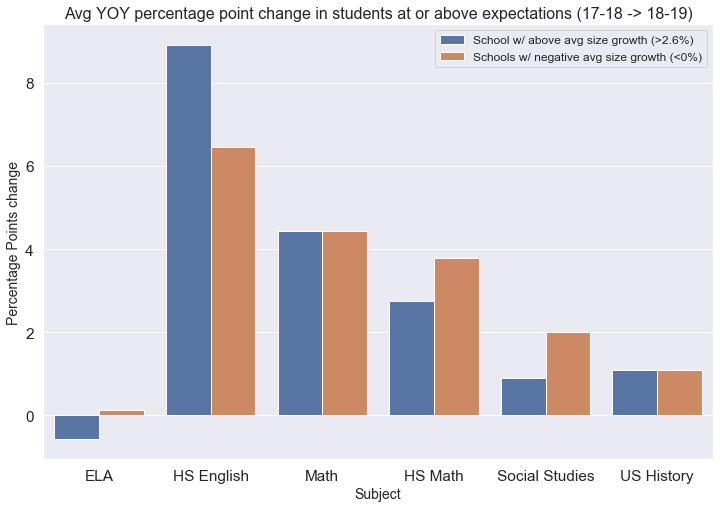

In [23]:
#Select a subset of the data that mirror the above tested groups
TNViz1 = AandE[(AandE['GR1819'] > 0.02602) | (AandE['GR1819'] <= 0)]

#Separate the data dependent on the 1818 Growth Rate
TNViz1['hue'] = ['School w/ above avg size growth (>2.6%)' if i > 0.02602 
                 else 'Schools w/ negative avg size growth (<0%)' for i in TNViz1['GR1819']]

#Generate a boxplot showing the average change in percentage points
order=['ELA', 'HS English', 'Math', 'HS Math', 'Social Studies', 'US History']
plt.figure(figsize=(12,8))
sns.set_style('darkgrid')
sns.set(font_scale=1.4)
sns.barplot(x='subject', y='Ac1819', hue='hue', order=order, data=TNViz1, ci=False)
plt.title('Avg YOY percentage point change in students at or above expectations (17-18 -> 18-19)', fontsize=16)
plt.ylabel('Percentage Points change', fontsize=14)
plt.xlabel('Subject', fontsize=14)
plt.legend(fontsize=12);

ELA and HS English are impacted by school size. 

While ELA scores stayed mostly flat over the year, change in school size did have a statistically significant difference. Those schools growing at a rate greater than the average TX YOY 17-18 -> 18-19 growth (>2.6%) will see an average decrease of 0.6 percentage points of students testing 'on' or 'mastered' proficiency levels, while those schools growing at a negative rate (<0%) would see an average increase in ELA scores of a mere 0.13 percentage points.

For HS English, average performance went up YOY. While schools that had growth rates above average saw an increase in 

### Texas Data Cleaning

In [24]:
#For each of the Enrollment and Academic data sets, load in the raw data and the 
#table key and replace the column headers in the data sets for ease of use
name = tuple(i for i in TX1617Key.NAME)
label = tuple(i for i in TX1617Key.LABEL)
TX1617.rename(columns={i:j for i,j in zip(name,label)}, inplace=True)

name = tuple(i for i in TX1718Key.NAME)
label = tuple(i for i in TX1718Key.LABEL)
TX1718.rename(columns={i:j for i,j in zip(name,label)}, inplace=True)

name = tuple(i for i in TX1819Key.NAME)
label = tuple(i for i in TX1819Key.LABEL)
TX1819.rename(columns={i:j for i,j in zip(name,label)}, inplace=True)


name = tuple(i for i in TX1617AcaKey.NAME)
label = tuple(i for i in TX1617AcaKey.LABEL)
TX1617Aca.rename(columns={i:j for i,j in zip(name,label)}, inplace=True)

name = tuple(i for i in TX1718AcaKey.NAME)
label = tuple(i for i in TX1718AcaKey.LABEL)
TX1718Aca.rename(columns={i:j for i,j in zip(name,label)}, inplace=True)

name = tuple(i for i in TX1819AcaKey.NAME)
label = tuple(i for i in TX1819AcaKey.LABEL)
TX1819Aca.rename(columns={i:j for i,j in zip(name,label)}, inplace=True)

In [25]:
#Extract the enrollment numbers from the enrollment data sets
TX1617Enrl = TX1617[['Campus Number', 'Total Number of Students']]
TX1718Enrl = TX1718[['Campus Number', 
                     'Campus 2018 Student: All Students Count']]
TX1819Enrl = TX1819[['Campus Number', 
                     'Campus 2019 Student: All Students Count']]

In [26]:
#Generate an Enrollment data frame from the enrollment data sets.
#The use of right join maintains more information in the later years, retaining the most recent/relevant information.
TXEnrollment = pd.merge(TX1617Enrl, TX1718Enrl, how='right', on='Campus Number')
TXEnrollment = pd.merge(TXEnrollment, TX1819Enrl, how='right', on='Campus Number')

TXEnrollment = TXEnrollment.rename(columns={'Campus Number': 'Campus', 'Total Number of Students': '1617Enrlmnt',
                                            'Campus 2018 Student: All Students Count': '1718Enrlmnt',
                                            'Campus 2019 Student: All Students Count': '1819Enrlmnt'})

TXEnrollment.head()

,Campus,1617Enrlmnt,1718Enrlmnt,1819Enrlmnt
0,'001902001,173.0,168.0,179
1,'001902041,136.0,146.0,119
2,'001902103,267.0,261.0,266
3,'001903001,394.0,383.0,376
4,'001903041,294.0,277.0,261


In [27]:
#Inspect the head of the 2018-19 academic data
TX1819Aca[['Campus Number',
           'Campus 2019 Domain 1A: Meets Grade Level STD, Summed Grades 3-12, All Students All Tests Rate']].head(2)

,Campus Number,"Campus 2019 Domain 1A: Meets Grade Level STD, Summed Grades 3-12, All Students All Tests Rate"
0,'001902001,67
1,'001902041,57


In [28]:
#Inspect the key to determine the All students test performance column
list(TX1718AcaKey[TX1718AcaKey['LABEL'].str.contains('All Students')]['LABEL'])[:5]

['Campus 2018 Domain 1A: Summed Grades 3-12, All Students All Tests Performance Denominator',
 'Campus 2018 Domain 1A: Meets Grade Level STD, Summed Grades 3-12, All Students All Tests Numerator',
 'Campus 2018 Domain 1A: Meets Grade Level STD, Summed Grades 3-12, All Students All Tests Rate',
 'Campus 2018 Domain 1A: Masters Grade Level STD, Summed Grades 3-12, All Students All Tests Numerator',
 'Campus 2018 Domain 1A: Masters Grade Level STD, Summed Grades 3-12, All Students All Tests Rate']

In [29]:
#Inspect the head of the 2018-19 academic data
TX1718Aca[['Campus Number', 
           'Campus 2018 Domain 1A: Meets Grade Level STD, Summed Grades 3-12, All Students All Tests Rate']].head(2)

,Campus Number,"Campus 2018 Domain 1A: Meets Grade Level STD, Summed Grades 3-12, All Students All Tests Rate"
0,'001902001,58
1,'001902041,44


In [30]:
#For each of the academic tables, extract the test data and the campus number for unique join key
TX1617Academic = TX1617Aca[['Campus Number', 
                            'Campus 2017 STAAR Meets Grade Level: Rate of students meeting Grade Level Standard requirement for Two or More Subjects - All Rate']]

TX1718Academic = TX1718Aca[['Campus Number', 
                            'Campus 2018 Domain 1A: Meets Grade Level STD, Summed Grades 3-12, All Students All Tests Rate']]

TX1819Academic = TX1819Aca[['Campus Number',
                            'Campus 2019 Domain 1A: Meets Grade Level STD, Summed Grades 3-12, All Students All Tests Rate']]

#Generate the Texas academic table, joining on the Campus number (unique id). The right join retains the most recent data
TXAcademic = pd.merge(TX1617Academic, TX1718Academic, how='right', on='Campus Number')
TXAcademic = pd.merge(TXAcademic, TX1819Academic, how='right', on='Campus Number')

TXAcademic = TXAcademic.rename(columns={'Campus Number': 'Campus', 
                                        'Campus 2017 STAAR Meets Grade Level: Rate of students meeting Grade Level Standard requirement for Two or More Subjects - All Rate': '1617MeetsRate',
                                        'Campus 2018 Domain 1A: Meets Grade Level STD, Summed Grades 3-12, All Students All Tests Rate': '1718MeetsRate',
                                        'Campus 2019 Domain 1A: Meets Grade Level STD, Summed Grades 3-12, All Students All Tests Rate': '1819MeetsRate'})

TXAcademic.head()

,Campus,1617MeetsRate,1718MeetsRate,1819MeetsRate
0,'001902001,61,58,67
1,'001902041,45,44,57
2,'001902103,48,55,62
3,'001903001,52,57,63
4,'001903041,42,47,51


In [31]:
#Generate a table from the Enrollment and Academic performance
TXAandE = pd.merge(TXEnrollment, TXAcademic, how='inner', on='Campus')
print(len(TXAandE))

#Drop about 4% of data to remove N/As
TXAandE = TXAandE.dropna()
print(len(TXAandE))

TXAandE.head(2)

8194
7850


,Campus,1617Enrlmnt,1718Enrlmnt,1819Enrlmnt,1617MeetsRate,1718MeetsRate,1819MeetsRate
0,'001902001,173.0,168.0,179,61,58,67
1,'001902041,136.0,146.0,119,45,44,57


In [32]:
#instead of blanks or "*" characters, there were '.'s to convert to Nan values
TXAandE = TXAandE.replace('.', np.NaN)

#Use the to_numeric function to change the datatypes in the table
TXAandE[['1617Enrlmnt', '1718Enrlmnt', 
         '1819Enrlmnt', '1617MeetsRate',
         '1718MeetsRate', '1819MeetsRate']] = TXAandE[['1617Enrlmnt', '1718Enrlmnt',
                                                       '1819Enrlmnt', '1617MeetsRate',
                                                       '1718MeetsRate', '1819MeetsRate']].apply(pd.to_numeric)

TXAandE.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7850 entries, 0 to 7883
Data columns (total 7 columns):
Campus           7850 non-null object
1617Enrlmnt      7850 non-null float64
1718Enrlmnt      7850 non-null float64
1819Enrlmnt      7850 non-null int64
1617MeetsRate    7711 non-null float64
1718MeetsRate    7752 non-null float64
1819MeetsRate    7742 non-null float64
dtypes: float64(5), int64(1), object(1)
memory usage: 490.6+ KB


In [33]:
#Drop the columns where there was no growth rate for 1718 & 1819 Meets and Masters Rates
TXAandE = TXAandE[TXAandE['1617MeetsRate'] != -1]
TXAandE = TXAandE[TXAandE['1718MeetsRate'] != -1]
TXAandE = TXAandE[TXAandE['1819MeetsRate'] != -1]

#Generate a growth rate for schools' YOY enrollment
TXAandE['GR1718'] = round((TXAandE['1718Enrlmnt'] - TXAandE['1617Enrlmnt']) / TXAandE['1617Enrlmnt'], 4)
TXAandE['GR1819'] = round((TXAandE['1819Enrlmnt'] - TXAandE['1718Enrlmnt']) / TXAandE['1718Enrlmnt'], 4)

#Generate an academic performance rate change to measure proficiency change
TXAandE['AC1718'] = round(TXAandE['1718MeetsRate'] - TXAandE['1617MeetsRate'], 4)
TXAandE['AC1819'] = round(TXAandE['1819MeetsRate'] - TXAandE['1718MeetsRate'], 4)

#Drop null values in each of the AC columns
TXAandE = TXAandE.dropna(subset=['AC1718'])
TXAandE = TXAandE.dropna(subset=['AC1819'])

,1617Enrlmnt,1718Enrlmnt,1819Enrlmnt,1617MeetsRate,1718MeetsRate,1819MeetsRate,GR1718,GR1819,AC1718,AC1819
count,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000
mean,677.637600,679.021067,675.186133,43.944267,47.000267,48.105333,0.013326,-0.000578,3.056000,1.105067
std,529.807649,531.498879,530.254087,17.017811,15.528920,15.367927,0.168980,0.122688,6.890805,5.168416
min,16.000000,12.000000,12.000000,5.000000,9.000000,9.000000,-0.781200,-0.685500,-35.000000,-37.000000
25%,381.000000,385.000000,381.000000,31.000000,36.000000,37.000000,-0.042700,-0.045900,-1.000000,-2.000000
50%,575.500000,573.000000,564.000000,42.000000,45.000000,46.000000,-0.001700,-0.005200,3.000000,1.000000
75%,787.000000,788.000000,779.000000,54.000000,57.000000,58.000000,0.039525,0.035300,8.000000,4.000000
max,5931.000000,5675.000000,5680.000000,100.000000,100.000000,100.000000,5.790700,2.666700,42.000000,28.000000


In [34]:
#Find outliers by calculating +/- 3 standard deviations from the mean

a = {}
for i in ['GR1718', 'GR1819', 'AC1718', 'AC1819']:
    a[i] = (round(np.mean(TXAandE[i])-(3*(np.std(TXAandE[i]))),3), round(np.mean(TXAandE[i])+(3*(np.std(TXAandE[i]))),3))
    
a

{'GR1718': (-0.494, 0.52),
 'GR1819': (-0.369, 0.367),
 'AC1718': (-17.615, 23.727),
 'AC1819': (-14.399, 16.609)}

In [35]:
#Here I am removing outliers that are +/- 3 Stds away from mean.
TXAandE = TXAandE[(TXAandE['GR1718'] >= -0.494) & (TXAandE['GR1718'] <= 0.52)]
TXAandE = TXAandE[(TXAandE['GR1819'] >= -0.369) & (TXAandE['GR1819'] <= 0.367)]
TXAandE = TXAandE[(TXAandE['AC1718'] >= -17.615) & (TXAandE['AC1718'] <= 23.727)]
TXAandE = TXAandE[(TXAandE['AC1819'] >= -14.399) & (TXAandE['AC1819'] <= 16.609)]

TXAandE.describe()

,1617Enrlmnt,1718Enrlmnt,1819Enrlmnt,1617MeetsRate,1718MeetsRate,1819MeetsRate,GR1718,GR1819,AC1718,AC1819
count,7181.000000,7181.000000,7181.000000,7181.000000,7181.000000,7181.000000,7181.000000,7181.000000,7181.000000,7181.000000
mean,687.579446,686.514692,681.780114,44.039410,47.140231,48.221418,0.001027,-0.005860,3.100822,1.081186
std,529.023080,531.828649,530.195864,16.985287,15.461903,15.308289,0.088276,0.077084,6.483222,4.742942
min,16.000000,17.000000,21.000000,6.000000,9.000000,9.000000,-0.485600,-0.368400,-17.000000,-14.000000
25%,397.000000,396.000000,391.000000,31.000000,36.000000,37.000000,-0.042500,-0.045400,-1.000000,-2.000000
50%,583.000000,579.000000,570.000000,42.000000,45.000000,46.000000,-0.002500,-0.005700,3.000000,1.000000
75%,792.000000,792.000000,783.000000,54.000000,57.000000,58.000000,0.037500,0.033200,7.000000,4.000000
max,5931.000000,5675.000000,5680.000000,100.000000,100.000000,100.000000,0.513200,0.364500,23.000000,16.000000


### Texas Analysis

In [36]:
#Since the Growth Rate is essentially 0, I choose to separate out the academic performance 
#for schools +/- 2% growth

# Test 1 is positive
# Test 2 is negative growth rate

Test1 = TXAandE[TXAandE['GR1718'] > 0.02]
Test2 = TXAandE[TXAandE['GR1718'] <= -0.02]

print(len(Test1))
print(len(Test2))

print(levene(Test1['AC1718'], Test2['AC1718']))

2496
2741
LeveneResult(statistic=0.37859278397554413, pvalue=0.5383840644443216)


In [37]:
print('Positve GR (>2%) vs Negative GR (<-2%)')
print(round(np.mean(Test1['AC1718']),3), round(np.mean(Test2['AC1718']),3), ttest_ind(Test1['AC1718'], Test2['AC1718']))

Positve GR (>2%) vs Negative GR (<-2%)
2.474 4.034 Ttest_indResult(statistic=-8.847636925311917, pvalue=1.2032092814043822e-18)


No handles with labels found to put in legend.


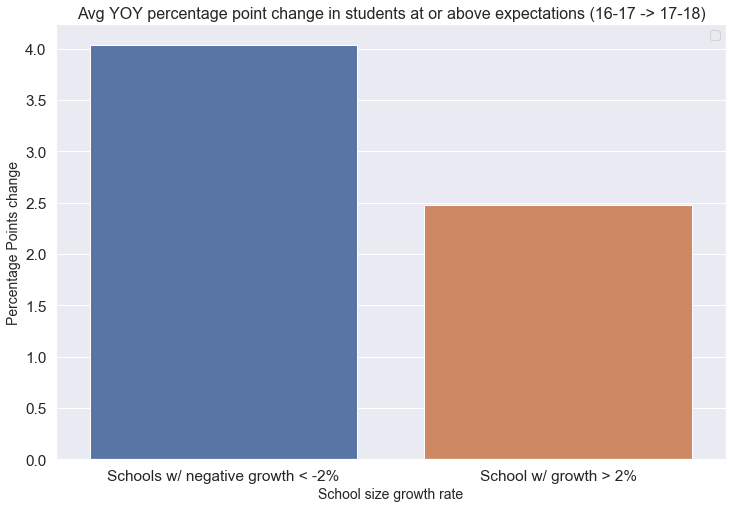

In [38]:
#Generate a data frame to mimic the above test
TXViz = TXAandE[(TXAandE['GR1718'] > 0.02) | (TXAandE['GR1718'] <= -0.02)]

#Designate the data by growth rate
TXViz['hue'] = ['School w/ growth > 2%' if i > 0.02 
                else 'Schools w/ negative growth < -2%' for i in TXViz['GR1718']]

#Generate a boxplot for the data
plt.figure(figsize=(12,8))
sns.set_style('darkgrid')
sns.set(font_scale=1.4)
sns.barplot(x='hue', y='AC1718', data=TXViz, ci=False)
plt.title('Avg YOY percentage point change in students at or above expectations (16-17 -> 17-18)', fontsize=16)
plt.ylabel('Percentage Points change', fontsize=14)
plt.xlabel('School size growth rate', fontsize=14)
plt.legend(fontsize=12);

In [39]:
#Again, mean 1819 Growth Rate was essentially 0, so I generate some distance with +/- 2%

# Test 1 is positive
# Test 2 is negative growth rate

Test1 = TXAandE[TXAandE['GR1819'] > 0.02]
Test2 = TXAandE[TXAandE['GR1819'] <= -0.02]

print(len(Test1))
print(len(Test2))

#Calculate the Levene test for equal variance
print(levene(Test1['AC1819'], Test2['AC1819']))

2298
2897
LeveneResult(statistic=5.98381870160714, pvalue=0.014470658778957295)


In [40]:
#Levene proved unequal variance so we substitute Welch's test
print('Positve GR vs Negative GR')
print(round(np.mean(Test1['AC1819']),3), round(np.mean(Test2['AC1819']),3), 
      ttest_ind(Test1['AC1819'], Test2['AC1819'], equal_var=False))

Positve GR vs Negative GR
0.837 1.303 Ttest_indResult(statistic=-3.4812019691882337, pvalue=0.0005034321622791004)


No handles with labels found to put in legend.


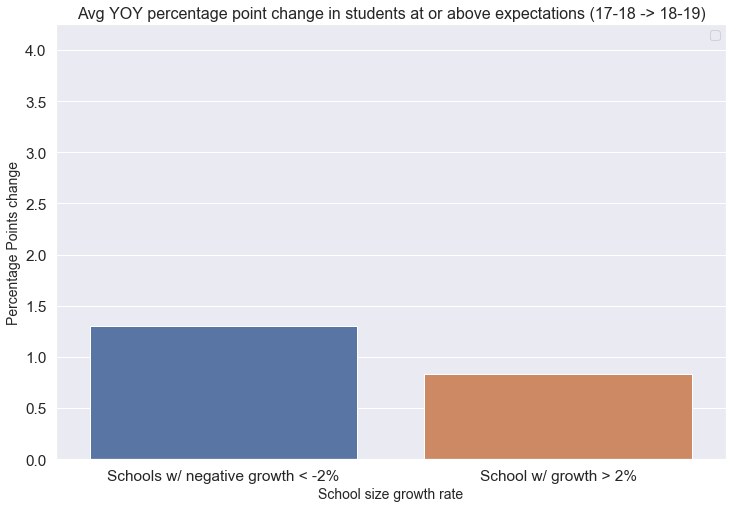

In [46]:
#Generate a data frame to match the above comparison test
TXViz1 = TXAandE[(TXAandE['GR1819'] > 0.02) | (TXAandE['GR1819'] <= -0.02)]

#Designate the data by growth rate
TXViz1['hue'] = ['School w/ growth > 2%' if i > 0.02 
                else 'Schools w/ negative growth < -2%' for i in TXViz1['GR1819']]

#Generate a boxplot for the data
plt.figure(figsize=(12,8))
order = ['Schools w/ negative growth < -2%', 'School w/ growth > 2%']
sns.set_style('darkgrid')
sns.set(font_scale=1.4)
sns.barplot(x='hue', y='AC1819', data=TXViz1, order=order, ci=False)
plt.title('Avg YOY percentage point change in students at or above expectations (17-18 -> 18-19)', fontsize=16)
plt.ylabel('Percentage Points change', fontsize=14)
plt.xlabel('School size growth rate', fontsize=14)
plt.ylim(0,4.25)
plt.legend(fontsize=12);